In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from main_functions import *

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
DATA = 'data/'

In [4]:
plt.rcParams["figure.facecolor"] = 'white'

In [5]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
get_name = dict(zip(proteins, protein_names))
measures = ['nodes', 'edges', 'weight', 'distance']

In [6]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]

In [7]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

In [8]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [9]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [10]:
def GetScores(functional_percentage, network_mincount, measure_cutoffs, thresh=9.0, mean=True):
    """Return precision, recall and prediction percentage scores. Returns list of lists, [precision, recall,
    predper] for each protein and the mean, if mean == True """
    which_scores = ['Precision', 'Recall', 'Improvement', 'SSPs']
    scores = {score:[] for score in which_scores}
    for protein in proteins:
        network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        funct_extremes = GetPercentage(functional_percentage, 'lowest', functional_data[protein])
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)
    
        scores['Recall'].append(ToPercentage(how_many, funct_extremes))
        precision_score = ToPercentage(how_many, network_extremes)
        scores['Precision'].append(precision_score)
        scores['Improvement'].append(round(precision_score/40, 2))
        ssps = ToPercentage(network_extremes, positions)
        scores['SSPs'].append(ssps)
        
    if mean:
        for score in which_scores:
            scores[score].append(round(np.mean(scores[score]), 2))
            
    return scores

In [11]:
def GetScoresGain(functional_percentage, network_mincount, measure_cutoffs, thresh=9.0, mean=True):
    """Return precision, recall and prediction percentage scores. Returns dict with list of three lists, containing 
    the values for each of the 5 proteins and if mean == True, the mean."""
    which_scores = ['Precision', 'Recall', 'Improvement', 'SSPs']
    scores = {score:[] for score in which_scores}
    for protein in proteins:
        
        network_extremes_loss = GetNetworkExtremes(protein, network_mincount, measure_cutoffs, thresh=thresh)
        total_positions = functional_data[protein].columns
        funct_extremes = GetPercentage(functional_percentage, 'highest', functional_data[protein])
        network_extremes = set([pos for pos in total_positions if pos not in network_extremes_loss])
        #network_extremes = network_extremes_loss 
        
        how_many = len(network_extremes.intersection(funct_extremes))
        positions = len(functional_data[protein].columns)
    
        scores['Recall'].append(ToPercentage(how_many, funct_extremes))
        precision_score = ToPercentage(how_many, network_extremes)
        scores['Precision'].append(precision_score)
        scores['Improvement'].append(round(precision_score/(functional_percentage*100), 2))
        ssps = ToPercentage(network_extremes, positions)
        scores['SSPs'].append(ssps)
        
    if mean:
        for score in which_scores:
            scores[score].append(round(np.mean(scores[score]), 2))
    return scores

## Loss predictions

In [12]:
def BoxenData(functional_percentage, network_mincount, measure_cutoffs, thresh=9.0, mean=True, gain=False):
    """Return DataFrame with Recall, Precision and Improvement scores for 5 proteins and mean, por prediction
    based on input parameters. Loss if gain == False, gain if gain == True."""
    proteins2 = proteins+['Mean']
    which_scores = ['Precision', 'Recall', 'Improvement']
    data = list()
    for thresh in thresholds[10:]:
        function = GetScores if gain == False else GetScoresGain
        scores = function(functional_percentage, network_mincount, measure_cutoffs, thresh=thresh)
        for name in which_scores:
            for i, protein in enumerate(proteins2):
                # add lines [protein, thresh, score, type]
                data.append([protein, thresh, scores[name][i], name])
    df = pd.DataFrame(data, columns=['Protein','Threshold','Score', 'Name'] )
    df['Protein'] = df['Protein'].replace(get_name)
    return df 

In [13]:
precision = BoxenData(0.4,3,[1.5]*3)
recall = BoxenData(0.4, 2, [1]*3)
both = BoxenData(0.4, 2, [1.5]*3)
gain = BoxenData(0.4, 1, [1]*3, gain=True)

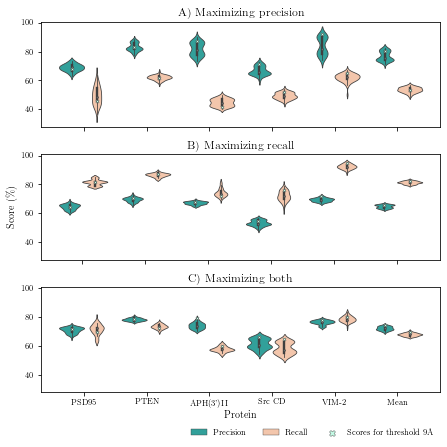

In [14]:
titles = ['A) Maximizing precision', 'B) Maximizing recall', 'C) Maximizing both']
fig, axes = plt.subplots(3,1, figsize=(6.1, 6.1), sharey=True, constrained_layout=True)

for j, (ax, data) in enumerate([(axes[0], precision), (axes[1], recall), (axes[2], both)]):
    g = sns.violinplot(x='Protein', y='Score', data=data[data['Name']!='Improvement'], hue='Name',
                col_order=data.Protein.unique(), sharex=True, palette=['#20b2aa', '#ffc3a0'], linewidth=0.8, ax=ax)
    ax.get_legend().remove()
    
    if j!=2:
        ax.set_xticklabels([])
        ax.set_xlabel('')
    
    if j!=1:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Score (\%)')
        
    ax.title.set_text(titles[j])   

    for i, protein in enumerate(data.Protein.unique()):
        x = [i-1/5, i+1/5]
        y = data[(data.Protein==protein) & (data.Threshold==9.) & (data.Name != 'Improvement')]['Score'].values
        ax.scatter(x=x, y=y, c='#c7ffe9', zorder=3, s=10, marker='X', edgecolors='#3F3F3F', linewidths=0.4)
#'#afd7ce'      
ax=axes[2]
X = ax.scatter([], [], marker='X', c='#c7ffe9', label='Scores for threshold 9\AA{}', edgecolors='#3F3F3F', 
               linewidths=0.4)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, -0.28), loc='upper right', ncol=3, frameon=False)

fig = plt.gcf()
fig.savefig('figures/loss_scores.png', dpi=300)

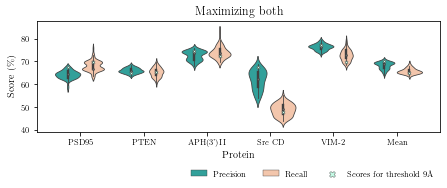

In [136]:
fig, ax = plt.subplots(1,1, figsize=(6.1, 2.5), sharey=True, constrained_layout=True)

data = gain
g = sns.violinplot(x='Protein', y='Score', data=data[data['Name']!='Improvement'], hue='Name',
                col_order=data.Protein.unique(), sharex=True, palette=['#20b2aa', '#ffc3a0'], linewidth=0.8, ax=ax)
ax.get_legend().remove()

ax.set_ylabel('Score (\%)')

ax.title.set_text('Maximizing both')   

for i, protein in enumerate(data.Protein.unique()):
    x = [i-1/5, i+1/5]
    y = data[(data.Protein==protein) & (data.Threshold==9.) & (data.Name != 'Improvement')]['Score'].values
    ax.scatter(x=x, y=y, c='#c7ffe9', zorder=3, s=10, marker='X', edgecolors='#3F3F3F', linewidths=0.4)
    
#'#afd7ce'      
X = ax.scatter([], [], marker='X', c='#c7ffe9', label='Scores for threshold 9\AA{}',  edgecolors='#3F3F3F', 
               linewidths=0.4)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, -0.28), loc='upper right', ncol=3, frameon=False)

fig = plt.gcf()
fig.savefig('figures/gain_scores.png', dpi=300)

In [ ]:
## Sensitivity predictions

In [40]:
## Mean scores and standard deviations for each prediction
## Max precision
prediction = GetScores(0.4, 3, [1.5]*3, mean=False)
for measure in prediction.keys():
    num = f"{measure}, {np.mean(prediction[measure]):.2f} +- {np.std(prediction[measure]):.2f}"
    print(num)

Precision, 80.54 +- 9.28
Recall, 53.10 +- 9.14
Improvement, 2.02 +- 0.23
SSPs, 26.32 +- 3.88


In [41]:
## Max recall
prediction = GetScores(0.4, 2, [1]*3, mean=False)
for measure in prediction.keys():
    num = f"{measure}, {np.mean(prediction[measure]):.2f} +- {np.std(prediction[measure]):.2f}"
    print(num)

Precision, 65.70 +- 6.16
Recall, 82.18 +- 8.08
Improvement, 1.64 +- 0.16
SSPs, 50.00 +- 4.33


In [42]:
## Max both
prediction = GetScores(0.4, 2, [1.5]*3, mean=False)
for measure in prediction.keys():
    num = f"{measure}, {np.mean(prediction[measure]):.2f} +- {np.std(prediction[measure]):.2f}"
    print(num)

Precision, 74.72 +- 5.08
Recall, 69.32 +- 6.98
Improvement, 1.87 +- 0.13
SSPs, 37.04 +- 3.72


In [ ]:
## Robustness predictions

In [43]:
## Mean scores and standard deviations for each prediction
## Max precision 
prediction = GetScoresGain(0.4, 1, [1]*3, mean=False)
for measure in prediction.keys():
    num = f"{measure}, {np.mean(prediction[measure]):.2f} +- {np.std(prediction[measure]):.2f}"
    print(num)

Precision, 70.40 +- 4.65
Recall, 65.06 +- 8.86
Improvement, 1.76 +- 0.12
SSPs, 36.78 +- 4.67
